# Machine Learning Boilerplate Workflow (PCA Example)

## Define Problem

1. Goal: Use PCA to reduce feature dimensions and improve interpretability/speed
2. Then train a classifier (Logistic Regression) on reduced features


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

## EDA

In [2]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Shape:", X.shape)
X.head()

Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


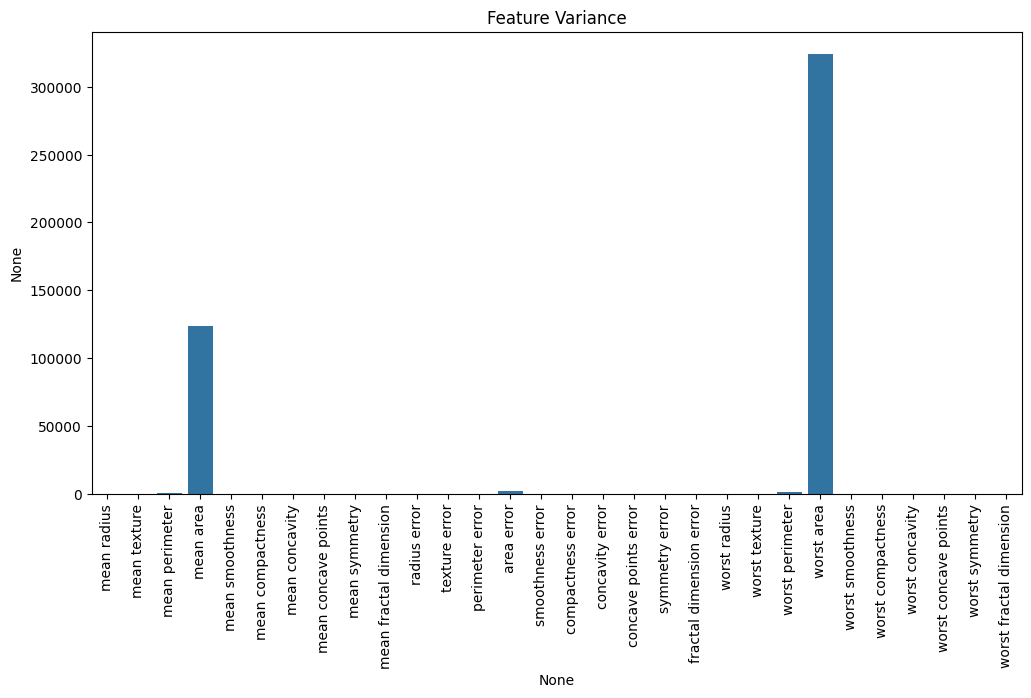

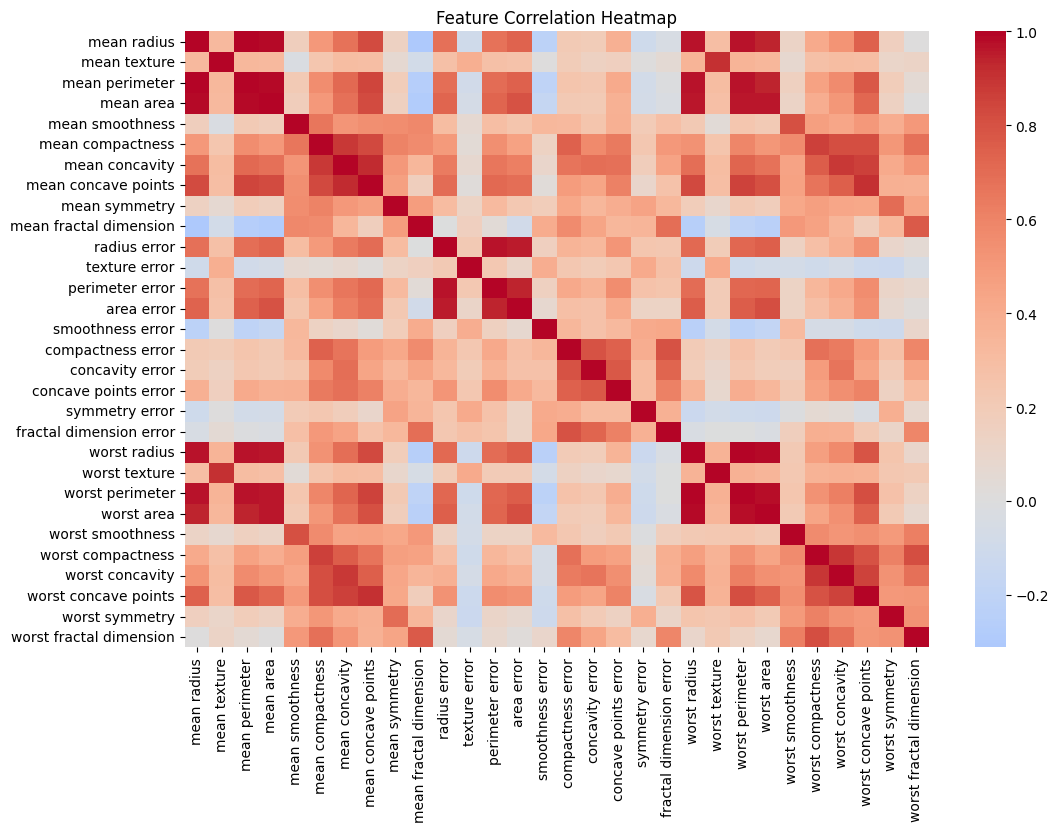

In [3]:
# Variance per feature
plt.figure(figsize=(12,6))
sns.barplot(x=X.columns, y=X.var())
plt.xticks(rotation=90)
plt.title("Feature Variance")
plt.show()

# Correlation heatmap (multicollinearity hint)
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

**PCA is most useful when features are highly correlated (to avoid redundancy).**

## Data Preprocessing

**PCA needs standardization so all features contribute equally.**

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Fit PCA
**Rule of thumb: pick the smallest number of components that explain ~95% variance.**

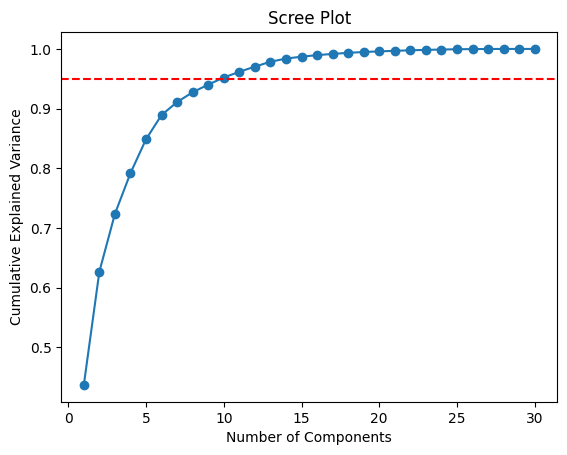

In [5]:
pca = PCA()
pca.fit(X_train)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance)+1), explained_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.axhline(y=0.95, color="r", linestyle="--")
plt.show()

## Transfor Data

In [6]:
# Keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_pca.shape)

Original shape: (455, 30)
Reduced shape: (455, 10)


In [13]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [14]:
explained_variance

array([0.43714936, 0.1897536 , 0.09683623, 0.06816176, 0.05676   ,
       0.04062881, 0.02172055, 0.01640012, 0.01280898, 0.01185151])

In [15]:
cumulative_variance

array([0.43714936, 0.62690296, 0.72373919, 0.79190095, 0.84866096,
       0.88928976, 0.91101032, 0.92741043, 0.94021942, 0.95207093])

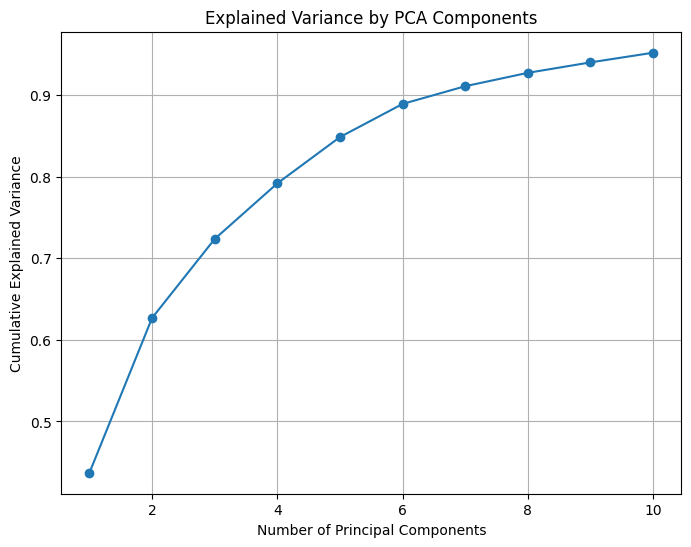

In [16]:
# Step 4: Scree plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

## Train a Classifier on the Transformed Data

Accuracy (with PCA): 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



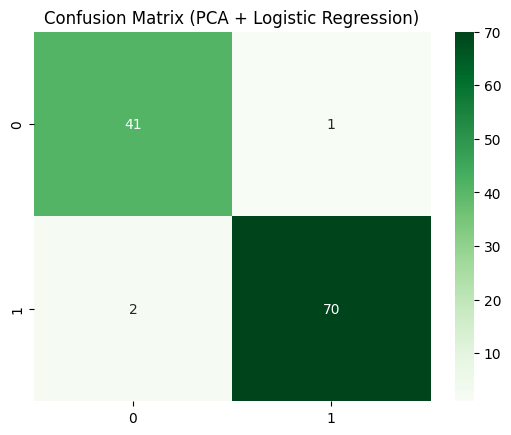

In [7]:
# Train classifier with PCA features
clf_pca = LogisticRegression(max_iter=500, random_state=42)
clf_pca.fit(X_train_pca, y_train)

y_pred_pca = clf_pca.predict(X_test_pca)

print("Accuracy (with PCA):", accuracy_score(y_test, y_pred_pca))
print("Classification Report:\n", classification_report(y_test, y_pred_pca))

sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (PCA + Logistic Regression)")
plt.show()

## Compare with Original (No PCA)

In [8]:
clf_orig = LogisticRegression(max_iter=500, random_state=42)
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)

print("Accuracy (without PCA):", accuracy_score(y_test, y_pred_orig))


Accuracy (without PCA): 0.9824561403508771


Usually, PCA sacrifices a tiny bit of accuracy for speed + generalization.

## Interpretation

- Each principal component = linear combination of original features.

You can check loadings (feature importance in components):

In [11]:
# Show first 5 principal components
pc_df = pd.DataFrame(pca.components_, columns=data.feature_names)
print("Principal Component Loadings:\n")
pc_df.head()

Principal Component Loadings:



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.209553,0.096970,0.218931,0.208837,0.144305,0.248621,0.265735,0.260314,0.152274,0.080586,...,0.216850,0.098464,0.226259,0.210008,0.129787,0.218599,0.241708,0.253625,0.140402,0.143141
1,-0.246822,-0.072770,-0.228881,-0.237899,0.152118,0.127102,0.048790,-0.054708,0.178100,0.360062,...,-0.232857,-0.057794,-0.214070,-0.225822,0.142935,0.122586,0.083802,-0.030365,0.131186,0.261007
2,0.015913,0.089428,0.013748,0.046915,-0.113359,-0.073177,0.002383,-0.023734,-0.063553,-0.038241,...,-0.027994,-0.015791,-0.030384,-0.000839,-0.262173,-0.237883,-0.176754,-0.167914,-0.276416,-0.242958
3,-0.045646,0.604623,-0.046306,-0.057512,-0.139296,-0.025989,-0.021822,-0.067657,-0.067747,-0.036556,...,-0.016259,0.631241,-0.016406,-0.022925,-0.007942,0.099858,0.081070,-0.000398,0.032685,0.097709
4,0.034663,-0.043486,0.033052,0.010391,-0.309194,0.000809,0.080756,-0.035975,-0.333511,-0.033258,...,-0.000187,-0.083090,0.007271,-0.017840,-0.265374,0.090878,0.168822,0.045926,-0.308263,0.084011


## Grid Search

## ROC & AUC

## Bias Variance Trade Off

## save model

In [18]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
    # # - max_iter=500 → Increase iterations to make sure it converges
    #   (default 100 can fail for high-dimensional data).
    ("logreg", LogisticRegression(max_iter=500, random_state=42))
])

pipeline.fit(X, y)

# Save
joblib.dump(pipeline, "pca_logreg_pipeline.pkl")
print("Pipeline saved as pca_logreg_pipeline.pkl")

# Load & test
loaded_pipeline = joblib.load("pca_logreg_pipeline.pkl")
print("Reloaded Accuracy:", accuracy_score(y, loaded_pipeline.predict(X)))

Pipeline saved as pca_logreg_pipeline.pkl
Reloaded Accuracy: 0.9859402460456942


1. Imagine your dataset after PCA still has 50 features. Logistic Regression is trying to optimize ~50 weights plus intercept. With 100 iterations, the solver may not fully minimize the log-loss. By setting max_iter=500, you give it more breathing room to converge.
2. Logistic Regression in scikit-learn is not solved analytically (like Linear Regression with OLS). Instead, it’s optimized using iterative numerical solvers (like gradient descent variants, quasi-Newton methods, coordinate descent, etc., depending on solver).

That means:

    - The algorithm starts with some initial weights.
    - Then repeatedly updates them to minimize the loss function (log-likelihood).
    - This process continues until it either: Converges (loss stops improving within tolerance), or Hits the max_iter limit and stops prematurely.
3. Without it, you might get suboptimal weights (bad accuracy, misleading coefficients). By setting max_iter=500, you give it more breathing room to converge.